In [1]:
import os
import re
import pickle
import numpy as np
from mne import viz
from scipy import io
from matplotlib import colors, pyplot as plt
from sklearn import model_selection, ensemble, svm, discriminant_analysis, neighbors, linear_model

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.05

CLASSIFIER = 'SVM' # SVM, LDA, QDA, GradientBoosting, KNeighbors, SGD-LOG, SGD-PERC

FEATURE_PATH = 'C:\\Users\\Philipp\\Documents\\Caffeine\\Features{dose}\\Combined'.format(dose=CAF_DOSE)
PROJECT_PATH = '..\\data'

STAGES = ['AWA', 'AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']

In [3]:
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
with open(os.path.join(FEATURE_PATH, 'data_avg.pickle'), 'rb') as file:
    data = pickle.load(file)
with open(os.path.join(FEATURE_PATH, 'labels_avg.pickle'), 'rb') as file:
    labels = pickle.load(file)
with open(os.path.join(FEATURE_PATH, 'groups_avg.pickle'), 'rb') as file:
    groups = pickle.load(file)

In [5]:
scores = {}
for stage in STAGES:
    scores[stage] = {}
    
    current_features = {
        'PSD': [feature for name, feature in data[stage].items() if name.startswith('PSD')],
        'Entropy': [feature for name, feature in data[stage].items() if name.endswith('En')]
    }
    
    for name, features in current_features.items():
        scores[stage][name] = []
        
        for electrode in range(20):
            print(f'{stage}: Training {CLASSIFIER} on electrode {electrode + 1:2} with {name} features...', end='\r')
            if CLASSIFIER.lower() == 'svm':
                clf = svm.SVC(gamma='scale')
            elif CLASSIFIER.lower() == 'lda':
                clf = discriminant_analysis.LinearDiscriminantAnalysis()
            elif CLASSIFIER.lower() == 'qda':
                clf = discriminant_analysis.QuadraticDiscriminantAnalysis()
            elif CLASSIFIER.lower() == 'gradientboosting':
                clf = ensemble.GradientBoostingClassifier(n_estimators=100)
            elif CLASSIFIER.lower() == 'kneighbors':
                clf = neighbors.KNeighborsClassifier()
            elif CLASSIFIER.lower() == 'sgd-log':
                clf = linear_model.SGDClassifier(loss='log', max_iter=1000, tol=1e-3)
            elif CLASSIFIER.lower() == 'sgd-perc':
                clf = linear_model.SGDClassifier(loss='perceptron', max_iter=1000, tol=1e-3)

            x = np.concatenate(features, axis=1)[:,electrode::20]
            y = labels[stage]

            current = model_selection.permutation_test_score(estimator=clf,
                                                             X=x,
                                                             y=y,
                                                             groups=groups[stage],
                                                             cv=10,
                                                             n_permutations=1000,
                                                             n_jobs=-1)
            scores[stage][name].append(current)
        print()

AWA: Training LDA on electrode 20 with PSD features...
AWA: Training LDA on electrode 20 with Entropy features...
AWSL: Training LDA on electrode 20 with PSD features...
AWSL: Training LDA on electrode 20 with Entropy features...
NREM: Training LDA on electrode 20 with PSD features...
NREM: Training LDA on electrode 20 with Entropy features...
REM: Training LDA on electrode 20 with PSD features...
REM: Training LDA on electrode 20 with Entropy features...


In [7]:
with open(os.path.join('..', 'results', f'scores{CAF_DOSE}', f'scores_combined_{CLASSIFIER}.pickle'), 'wb') as file:
    pickle.dump(scores, file)

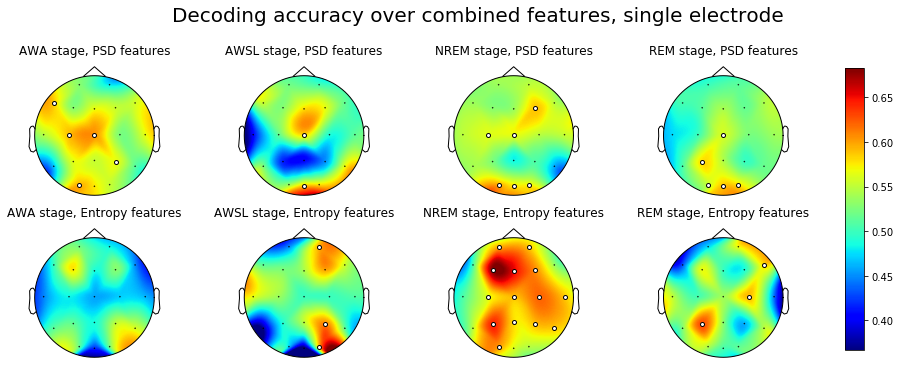

In [8]:
colormap = 'jet'

plt.figure(figsize=(18, 5))
plt.suptitle('Decoding accuracy over combined features, single electrode', y=1.1, fontsize=20)

all_scores = [[[score[0] for score in scores[stage][feature]] for feature in scores[stage].keys()] for stage in STAGES]
vmin = np.min(all_scores)
vmax = np.max(all_scores)

axes = []
subplot_index = 1
for feature in scores['AWA'].keys():
    for stage in STAGES:
        curr_acc = np.array([score[0] for score in scores[stage][feature]])
        curr_sig = np.array([score[2] for score in scores[stage][feature]])

        axes.append(plt.subplot(2, 4, subplot_index))
        plt.title(f'{stage} stage, {feature} features')
        mask = curr_sig < SIGNIFICANT_P
        viz.plot_topomap(curr_acc, sensor_pos, mask=mask, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
        subplot_index += 1

norm = colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=axes, shrink=0.95, aspect=15)
plt.savefig(f'..\\results\\figures{CAF_DOSE}\\Combined_{CLASSIFIER}_DA.png')
plt.show()